## Unsupervised Outlier Detection

1. Detect anomalies on seperate 3 seperate datasets 
    - Use different anomaly thresholds (1% -5%) 
    - And compare/verify similar dates and relationship 
    - Create a ranking/voting system for "popular" anomaly dates 
    - Additionally use Leave-one out method
2. Same but merge 3 datasets 
3. Create labels from anomalies and run supervised models
4. Optimization
5. Build a website 

## Prof Notes:
- which gets similar results to ensable
- dif models and contamination, and optimization

https://towardsdatascience.com/in-12-minutes-stocks-analysis-with-pandas-and-scikit-learn-a8d8a7b50ee7
https://stackoverflow.com/questions/47211866/how-to-mark-specific-data-points-in-matplotlib-graph

In [1]:
import warnings
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

# Import all models
import sklearn
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.loci import LOCI
from pyod.models.lscp import LSCP
from pyod.models.mcd import MCD
from pyod.models.mo_gaal import MO_GAAL
from pyod.models.ocsvm import OCSVM
from pyod.models.sos import SOS
from pyod.models.vae import VAE
# from pyod.models.xgbod import XGBOD 

from scipy import stats
pd.options.display.max_rows = 365

/opt/tljh/user/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


## Test on each Dataset Seperetly 

### Price Dataset
- load in data and scale

In [2]:
# read in data
price = pd.read_csv('btc_preprocessed.csv', index_col = 0)
# scale the data function using min-max
def scale(df):
    cols = df.columns
    index = df.index
    scaler = MinMaxScaler()
    X = scaler.fit_transform(df)
    X = pd.DataFrame(X)
    X.columns = cols
    X = X.set_index(index)
    return X
# save results in variable X
X = scale(price)
print(X.shape)
# data is standerdized 
X.describe()

,close,high,low,open,volumefrom,volumeto,CCI,ichimoku_leadSpanA,ichimoku_leadSpanB,MACD,...,ema_5,ema_10,ema_20,ema_30,ema_50,ema_100,ema_200,vwma,hull_Moving,Mkt_Cap
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,...,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,0.309506,0.323185,0.314349,0.311447,0.158511,0.165547,0.610031,0.360129,0.336818,0.567335,...,0.340866,0.341051,0.342827,0.340625,0.333706,0.318544,0.299443,0.373789,0.382758,0.312638
std,0.173618,0.181712,0.171755,0.174608,0.120752,0.150214,0.147846,0.207782,0.236865,0.167418,...,0.195385,0.203388,0.210658,0.215703,0.221806,0.226211,0.227650,0.186165,0.189751,0.172265
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.225885,0.230769,0.236921,0.226146,0.077413,0.061453,0.505965,0.254712,0.192137,0.470921,...,0.242474,0.231902,0.218803,0.202378,0.178738,0.152300,0.130824,0.282522,0.295410,0.232673
50%,0.264223,0.276441,0.267946,0.264287,0.124178,0.117303,0.592183,0.305660,0.234630,0.598206,...,0.287933,0.285601,0.273462,0.257315,0.255200,0.249962,0.231692,0.336388,0.337407,0.263083
75%,0.386708,0.406506,0.391708,0.390215,0.211678,0.220504,0.726902,0.458545,0.416687,0.650943,...,0.428683,0.437853,0.411689,0.418349,0.430019,0.422910,0.401396,0.498581,0.483048,0.386545
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 1.1 Run Models 

- VAE neurons adjusted (default nbr of neurons too much for blockchain dataset) 
    - for innitial run I would like to keep all the same
- VAE returns:<br>
UserWarning: Output model_2 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_2.

In [3]:
# time the code
import time
t0 = time.time()

# empty list to store outliers and inliners
df_outliers = []
scores_pred_lst = []
proba_lst = []
predict_rank_lst = []

# iterate over different outlier fractions 
outliers_fraction = [0.01,0.02,0.03,0.04,0.05]
random_state = 123 # set random state

for fraction in outliers_fraction:
    
    # Define 13 outlier detection tools to be compared
    classifiers = {#'AE' : AutoEncoder(contamination=outliers_fraction, random_state=random_state), # check why error
               'ABOD': ABOD(contamination = fraction),
              'CBLOF':CBLOF(check_estimator=False, random_state=random_state), # getting 0 
              'FB':FeatureBagging(LOF(n_neighbors=35),contamination=fraction,check_estimator=False,random_state=random_state),
              'HBOS': HBOS(contamination=fraction),
              'IF': IForest(contamination=fraction,random_state=random_state),
              'KNN': KNN(contamination=fraction),
              'Average KNN': KNN(method='mean',contamination=fraction),
              'OCSVM' : OCSVM(contamination=fraction),
              'SOS' : SOS(contamination=fraction),
              'LOF': LOF(n_neighbors=35, contamination = fraction),
              #'LOCI': LOCI(contamination = fraction), # takes a super long time + don't understand
              'VAE' : VAE(contamination=fraction, random_state=random_state) 
              }
    
    for i, (clf_name, clf) in enumerate(classifiers.items()):
        clf.fit(X)
        # predict raw anomaly score
        scores_pred = clf.decision_function(X) * -1 # WHY? * -1

        # prediction of a datapoint category outlier or inlier
        y_pred = clf.predict(X)

        # probability of outlier 
        probability = clf.predict_proba(X, method = 'linear')

        # predict rank
        predict_rank = clf._predict_rank(X)

        n_inliers = len(y_pred) - np.count_nonzero(y_pred)
        n_outliers = np.count_nonzero(y_pred == 1)

        # copy of dataframe
        dfx = X.copy()

        dfx[clf_name] = y_pred.tolist()
        #print(clf_name,'\n',i,clf,'\n',classifiers,'\n',classifiers.items())
        print('Outlier fraction: ', fraction)
        print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)
        #print('scores_pred: ', scores_pred)
        scores_pred_lst.append(scores_pred)
        df_outliers.append(dfx[clf_name]) 
        proba_lst.append(probability)
        predict_rank_lst.append(predict_rank)
t1 = time.time()
total = t1-t0

Outlier fraction:  0.01
OUTLIERS :  5 INLIERS :  360 ABOD
Outlier fraction:  0.01
OUTLIERS :  37 INLIERS :  328 CBLOF
Outlier fraction:  0.01
OUTLIERS :  0 INLIERS :  365 FB
Outlier fraction:  0.01
OUTLIERS :  4 INLIERS :  361 HBOS
Outlier fraction:  0.01
OUTLIERS :  4 INLIERS :  361 IF
Outlier fraction:  0.01
OUTLIERS :  3 INLIERS :  362 KNN
Outlier fraction:  0.01
OUTLIERS :  1 INLIERS :  364 Average KNN
Outlier fraction:  0.01
OUTLIERS :  4 INLIERS :  361 OCSVM
Outlier fraction:  0.01
OUTLIERS :  4 INLIERS :  361 SOS
Outlier fraction:  0.01
OUTLIERS :  2 INLIERS :  363 LOF
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 49)           0                                            
__________________________________________________________________________________________________
dens

/home/jupyter-ehren/.local/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output model_2 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_2.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 328 samples, validate on 37 samples
Epoch 1/100
328/328 [==============================] - 1s 2ms/step - loss: 110.2526 - val_loss: 63.7273
Epoch 2/100
328/328 [==============================] - 0s 104us/step - loss: 75.7278 - val_loss: 54.2889
Epoch 3/100
328/328 [==============================] - 0s 103us/step - loss: 65.0122 - val_loss: 48.8208
Epoch 4/100
328/328 [==============================] - 0s 103us/step - loss: 59.3450 - val_loss: 42.7259
Epoch 5/100
328/328 [==============================] - 0s 103us/step - loss: 54.6853 - val_loss: 39.1223
Epoch 6/100
328/328 [==============================] - 0s 104us/step - loss: 52.0227 - val_loss: 36.3632
Epoch 7/100
328/328 [==============================] - 0s 119us/step - loss: 51.2737 - val_loss: 35.8809
Epoch 8/100
328/328 [==============================] - 0s 101us/step - loss: 51.0503 - val_loss: 35.4381
Epoch 9/100
328/328 [==============================] - 0s 128us/step - loss: 50.9646 - val_loss: 35.2374
Epoch 10/10

/home/jupyter-ehren/.local/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output model_5 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_5.
  'be expecting any data to be passed to {0}.'.format(name))


Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 49)                0         
_________________________________________________________________
model_4 (Model)              [(None, 2), (None, 2), (N 19318     
_________________________________________________________________
model_5 (Model)              (None, 49)                16855     
Total params: 36,173
Trainable params: 36,173
Non-trainable params: 0
_________________________________________________________________
Train on 328 samples, validate on 37 samples
Epoch 1/100
328/328 [==============================] - 1s 2ms/step - loss: 115.6865 - val_loss: 97.2798
Epoch 2/100
328/328 [==============================] - 0s 105us/step - loss: 74.6734 - val_loss: 80.1766
Epoch 3/100
328/328 [==============================] - 0s 103us/step - loss: 62.4721 - val_loss: 72.4613
Epoch 4/100
328/328 [=====

/home/jupyter-ehren/.local/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output model_8 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_8.
  'be expecting any data to be passed to {0}.'.format(name))


Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 49)                0         
_________________________________________________________________
model_7 (Model)              [(None, 2), (None, 2), (N 19318     
_________________________________________________________________
model_8 (Model)              (None, 49)                16855     
Total params: 36,173
Trainable params: 36,173
Non-trainable params: 0
_________________________________________________________________
Train on 328 samples, validate on 37 samples
Epoch 1/100
328/328 [==============================] - 1s 2ms/step - loss: 116.9634 - val_loss: 92.1571
Epoch 2/100
328/328 [==============================] - 0s 106us/step - loss: 76.2211 - val_loss: 72.7482
Epoch 3/100
328/328 [==============================] - 0s 104us/step - loss: 64.5876 - val_loss: 63.6729
Epoch 4/100
328/328 [=====

/home/jupyter-ehren/.local/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output model_11 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_11.
  'be expecting any data to be passed to {0}.'.format(name))


Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 49)                0         
_________________________________________________________________
model_10 (Model)             [(None, 2), (None, 2), (N 19318     
_________________________________________________________________
model_11 (Model)             (None, 49)                16855     
Total params: 36,173
Trainable params: 36,173
Non-trainable params: 0
_________________________________________________________________
Train on 328 samples, validate on 37 samples
Epoch 1/100
328/328 [==============================] - 1s 2ms/step - loss: 119.3733 - val_loss: 84.8888
Epoch 2/100
328/328 [==============================] - 0s 108us/step - loss: 77.5501 - val_loss: 71.9424
Epoch 3/100
328/328 [==============================] - 0s 109us/step - loss: 64.7327 - val_loss: 63.6456
Epoch 4/100
328/328 [====

/home/jupyter-ehren/.local/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output model_14 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_14.
  'be expecting any data to be passed to {0}.'.format(name))


Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 49)                0         
_________________________________________________________________
model_13 (Model)             [(None, 2), (None, 2), (N 19318     
_________________________________________________________________
model_14 (Model)             (None, 49)                16855     
Total params: 36,173
Trainable params: 36,173
Non-trainable params: 0
_________________________________________________________________
Train on 328 samples, validate on 37 samples
Epoch 1/100
328/328 [==============================] - 1s 2ms/step - loss: 116.7092 - val_loss: 95.1480
Epoch 2/100
328/328 [==============================] - 0s 106us/step - loss: 75.7121 - val_loss: 77.7229
Epoch 3/100
328/328 [==============================] - 0s 102us/step - loss: 62.3644 - val_loss: 67.4819
Epoch 4/100
328/328 [====

In [4]:
print('Time to run: ',total,'s')
print('Nbr of lists',len(df_outliers))

Time to run:  44.76075267791748 s
Nbr of lists 55 (5 outlier fractions and 11 models)


In [ ]:
# save ranking table
#frequencies_df_price = frequencies_df
# save the outliers lists uniquely for later
prices_df = df_outliers
# probability lists
prices_proba = proba_lst
# rank lists
prices_rank_lst = predict_rank_lst

### 1.2 Seperate models per contamination
- Change if number of models change 

In [5]:
# seperate the outliers identified by models into lists by fraction 
# we know that it starts with 0.01 and how many models
frac_oo1 = df_outliers[0:11]
frac_oo2 = df_outliers[11:22]
frac_oo3 = df_outliers[22:33]
frac_oo4 = df_outliers[33:44]
frac_oo5 = df_outliers[44:]

# subset data so we only get dates where models identified them as outliers
def outlier_subset_function(outliers_lst):
# convert lists into df and transpose it
    btc_outliers = np.transpose(pd.DataFrame(outliers_lst))#.reset_index()
    
    outlier_dates = [] # this stores outlier dates
    #lenght = len(outlier_dates)
    for col in btc_outliers.columns:
        outliers = btc_outliers[btc_outliers[col] == 1] # subset outlier data
        outlier_dates.append(outliers.index.tolist()) # append the string/date 
        
        #lenght2 = len(outlier_dates)
        #nbr_dates = 
    return outlier_dates

In [6]:
# use the function to extract anomolous dates for each model and for each fraction
frac_oo1_outliers = outlier_subset_function(frac_oo1)
frac_oo2_outliers = outlier_subset_function(frac_oo2)
frac_oo3_outliers = outlier_subset_function(frac_oo3)
frac_oo4_outliers = outlier_subset_function(frac_oo4)
frac_oo5_outliers = outlier_subset_function(frac_oo5)

- depending on the following lenght, the number of lists to be joined in the function below is modified

In [7]:
# nbr of list = nbr of models
len(frac_oo1_outliers)

11

### 1.3 Get Unique Anomaly Dates per Contamination fraction
- purpuse of count_weight_outliers function is to find unique anomaly dates for a fraction 

**NOTE:** 
1. Nbr of lists in count_weight_outliers function has to be adjusted depending on how many models you are using
2. Weight_per_fraction col enumerator (division) needs to be changed depending on the number of models

In [8]:
def count_weight_outliers(outlier_dates): 
    # we have 11 anomaly model lists, joined them into one 
    # this function only does it for 1 fraction i.e. 0.01
    join =outlier_dates[0] + outlier_dates[1] + outlier_dates[2] + outlier_dates[3] + outlier_dates[4] +\
        outlier_dates[5] + outlier_dates[6] + outlier_dates[7] + outlier_dates[8] + outlier_dates[9] + outlier_dates[10]
    # find unique dates and count their occurance
    (unique, counts) = np.unique(join, return_counts=True)
    # convert this into an array from tuple
    frequencies = np.asarray((unique, counts)).T
    # now make it a dataframe
    frequencies_df = pd.DataFrame(frequencies)
    # name the columns so you can rever to them more easily 
    frequencies_df.columns = ['Date','Count_Anomaly_Date']
    # convert rank to integer type 
    frequencies_df.Count_Anomaly_Date = frequencies_df.Count_Anomaly_Date.astype(int)
    # how many times 11 models identified date as an anomaly for 1 fraction
        # again nbr of models for each fraction is 11, divide how many models identified the anomaly for specific date
        # with the number of total models = 11 
    frequencies_df['Weight_per_fraction'] = frequencies_df['Count_Anomaly_Date']/11 # ALTER THIS if nbr models changes
    # sort the dataframe by count of models that identified a specific date as anomaly
    frequencies_df = frequencies_df.sort_values(by='Count_Anomaly_Date', ascending = False)
    return frequencies_df

- **dates_per_fraction function** makes a dataframe to display number of anomaly dates per ALL fraction   

In [62]:
def dates_per_fraction(l1,l2,l3,l4,l5):
    # because we want to know nbr of unique anomalies per dates for all fraction we concat all on axis = 1
    d1 = pd.concat([count_weight_outliers(l1),count_weight_outliers(l2),count_weight_outliers(l3),
                    count_weight_outliers(l4),count_weight_outliers(l5)],axis=1)
    # As all columns now have the same names due to our count_weight_outliers I rename the columns
    d1.columns = ['001','Count1','W1','002','Count2','W2','003','Count3','W3','004','Count4','W4','005',
                'Count5','W5']
    
    # to nicely display all anomaly date fractions in 1 output we convert compute value_counts for the date
    # these are already unique dates so this returns nbr 1 for each date 
    d01 = d1['001'].value_counts()
    d02 = d1['002'].value_counts()
    d03 = d1['003'].value_counts()
    d04 = d1['004'].value_counts()
    d05 = d1['005'].value_counts()
    # concat these value counts now i.e. when one fraction has a values it will display 1 
        # when other doesnt it will display NaN
    l = pd.concat([d01,d02,d03,d04,d05],axis=1, sort=True)
    # to replace NaN with 0 when one fraction doesn't have that anomaly date we groupe it by count
        # the other way would be to replace NaN with 0
    l = l.groupby(l.index)['001','002','003','004','005'].agg('count')
    
    #lw = l.merge(d1[['001','W1']],left_on=l.index, right_on=d1['001'])
    #lw = l.merge(d1[['002','W2']],left_on=l.index, right_on=d1['002'])
    
    # here we sum up all the counts to get the total number of anomalies per fraction
    print('Outlier fraction 0.01 unique dates: ',l['001'].sum())
    print('Outlier fraction 0.02 unique dates: ',l['002'].sum())
    print('Outlier fraction 0.03 unique dates: ',l['003'].sum())
    print('Outlier fraction 0.04 unique dates: ',l['004'].sum())
    print('Outlier fraction 0.05 unique dates: ',l['005'].sum())
    # but we also want to see the df for all fraction so we return l
    return #l

dates_per_fraction(frac_oo1_outliers,frac_oo2_outliers,frac_oo3_outliers,frac_oo4_outliers,frac_oo5_outliers)

Outlier fraction 0.01 unique dates:  38
Outlier fraction 0.02 unique dates:  42
Outlier fraction 0.03 unique dates:  48
Outlier fraction 0.04 unique dates:  52
Outlier fraction 0.05 unique dates:  59


### 1.4 Anomaly Likelihood
- Assumption1: if all contamination levels vote for a date the date is more likely to be an anomaly
- Assumption2: if more models vote for a date the date is more likely to be an anomaly 
- So if both assumtions are true we could say date is even more likely to be an anomaly

In [49]:
# all fraction anomalous dates found merged 
def date_ranking(df1, df2, df3, df4, df5):
    # concat all the fractions into 1 dataframe on rows (axis = 0)
    # here we have duplicate values as some fractions/models identified same dates 
    concat = pd.concat([count_weight_outliers(df1),count_weight_outliers(df2),
            count_weight_outliers(df3),count_weight_outliers(df4), count_weight_outliers(df5)], 
            axis = 0)
    concat.columns = ['Date','ModelAnomaly_Vote','Weight_per_fraction']
    # count_weight_outliers function provides unique dates per contamination level
        # so if we group/value_counts on date, the date can be counted 5 times max as we have 1%-5% contamination
    # here we answer how many times a date was selected in ALL fractions (0.01 - 0.05) 
    allFractions_dateAnomaly = pd.DataFrame(concat.Date.value_counts()).reset_index()
    allFractions_dateAnomaly.columns = ['Date','AllContaminations_Vote']
 
    # how many models voted in all fractions combined 
    # sum of nbr of models that selected a date as an anomaly (in all contamination levels)
    model_vote = pd.DataFrame(concat.groupby("Date")['ModelAnomaly_Vote'].agg('sum')).reset_index()
    
    # sum the number of models that voted for a date (in all contamination levels)
    sum_ModelVotes = concat['ModelAnomaly_Vote'].sum()
    
    # merge it with anomalyCount_Fractions df so that dates match 
    merged_inner = pd.merge(left=allFractions_dateAnomaly, right=model_vote, on='Date')
    
    # model vote weight - if more models voted for a date we could assume its more likely an anomaly
    # model votes for 1 date / total model anomaly votes (665) in all contamination levels
    merged_inner['weight_anomaly_models'] = merged_inner.ModelAnomaly_Vote/sum_ModelVotes
    
    # Sort based on highest contamination anomaly count and highest model anomaly vote
    merged_inner = merged_inner.sort_values(["AllContaminations_Vote", "ModelAnomaly_Vote"], ascending = (False, False))
    return merged_inner

In [52]:
price_anomalies = date_ranking(frac_oo1_outliers,frac_oo2_outliers,frac_oo3_outliers,frac_oo4_outliers,frac_oo5_outliers)
print('Unique Anomaly Dates: ',len(price_anomalies.Date.unique()))
price_anomalies

Unique Anomaly Dates:  73


,Date,AllContaminations_Vote,ModelAnomaly_Vote,weight_anomaly_models
11,2018-01-16,5,36,0.054135
43,2018-01-17,5,32,0.048120
25,2018-01-06,5,31,0.046617
10,2018-01-01,5,30,0.045113
17,2018-01-05,5,29,0.043609
37,2018-01-07,5,24,0.036090
15,2018-01-08,5,22,0.033083
36,2018-01-02,5,21,0.031579
40,2018-01-03,5,21,0.031579
35,2018-01-04,5,20,0.030075


### 1.5 Borderline probability analysis
- e.g. the probability was 51% that date is an anomaly --> whats the realtionships
    - I think it's similar to predict() where I get labels not ratios (based on threshold it labels?)
    - predict_proba(): Predict the probability of a sample being outlier using the fitted detector.
    - simply use Min-max conversion to linearly transform the outlier scores into the range of [0,1]. 
    - Description of labeling formula vs probabilty:
    https://pyod.readthedocs.io/en/latest/_modules/pyod/models/base.html#BaseDetector.predict

In [33]:
import sys
np.set_printoptions(threshold=100)
prices_proba[0][:10]

array([[2.26869892e-07, 9.99999773e-01],
       [1.22951083e-04, 9.99877049e-01],
       [3.55243856e-04, 9.99644756e-01],
       [4.31716397e-04, 9.99568284e-01],
       [3.90444856e-05, 9.99960956e-01],
       [1.49117160e-05, 9.99985088e-01],
       [8.06483994e-05, 9.99919352e-01],
       [3.57676071e-05, 9.99964232e-01],
       [2.57806667e-05, 9.99974219e-01],
       [1.64204572e-05, 9.99983580e-01]])

## 2. Blockhain Dataset 
- **Note**
    - no feature engineering added to this dataset
    - as we defined functions above here we only need to call them on a new dataset 
    - exeption is model code so we can adjust the hyperparameters

In [54]:
block = pd.read_csv('blockchain18.csv', index_col = 0)
X = scale(block)
print(X.shape)
X.describe()

(365, 14)


,active_addresses,average_transaction_value,block_height,block_size,block_time,current_supply,difficulty,hashrate,large_transaction_count,new_addresses,transaction_count,transaction_count_all_time,unique_addresses_all_time,zero_balance_addresses_all_time
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,0.312659,0.224696,0.513188,0.577511,0.325309,0.513188,0.550890,0.476739,0.170867,0.224342,0.303136,0.482607,0.507523,0.518616
std,0.171182,0.136495,0.290541,0.223873,0.162468,0.290539,0.301799,0.243572,0.152479,0.133257,0.152195,0.275745,0.276457,0.275090
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.212106,0.132698,0.262062,0.417905,0.210205,0.262065,0.287124,0.268642,0.098229,0.151384,0.198545,0.246273,0.271502,0.300481
50%,0.279694,0.196649,0.517795,0.610013,0.302476,0.517790,0.575492,0.476230,0.134256,0.212049,0.281559,0.464341,0.496377,0.509794
75%,0.361409,0.287395,0.770601,0.771129,0.417515,0.770599,0.855096,0.684369,0.189775,0.265077,0.394768,0.709336,0.739602,0.748531
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 2.1 Run Models

- Adjusted neurons for VAE (not enogh features for default setting)

In [55]:
# time the code
import time
t0 = time.time()

# empty list to store outliers and inliners
df_outliers = []
scores_pred_lst = []
proba_lst = []
predict_rank_lst = []

for fraction in outliers_fraction:
    # Define 13 outlier detection tools to be compared
    classifiers = {#'AE' : AutoEncoder(contamination=outliers_fraction, random_state=random_state), # check why error
               'ABOD': ABOD(contamination = fraction),
              'CBLOF':CBLOF(check_estimator=False, random_state=random_state), # getting 0 
              'FB':FeatureBagging(LOF(n_neighbors=35),contamination=fraction,check_estimator=False,random_state=random_state),
              'HBOS': HBOS(contamination=fraction),
              'IF': IForest(contamination=fraction,random_state=random_state),
              'KNN': KNN(contamination=fraction),
              'Average KNN': KNN(method='mean',contamination=fraction),
              'OCSVM' : OCSVM(contamination=fraction),
              'SOS' : SOS(contamination=fraction),
              'LOF': LOF(n_neighbors=35, contamination = fraction),
              #'LOCI': LOCI(contamination = fraction), # takes a super long time + don't understand
              'VAE' : VAE(contamination=fraction, random_state=random_state,encoder_neurons=[56, 28, 14],
                         decoder_neurons=[14,28,56]) # default nbr of neurons too much for blockchain dataset
              }

    for i, (clf_name, clf) in enumerate(classifiers.items()):
        clf.fit(X)
        # predict raw anomaly score
        scores_pred = clf.decision_function(X) * -1 # WHY? * -1

        # prediction of a datapoint category outlier or inlier
        y_pred = clf.predict(X)

        # probability of outlier 
        probability = clf.predict_proba(X, method = 'linear')

        # predict rank
        predict_rank = clf._predict_rank(X)

        n_inliers = len(y_pred) - np.count_nonzero(y_pred)
        n_outliers = np.count_nonzero(y_pred == 1)

        # copy of dataframe
        dfx = X.copy()

        dfx[clf_name] = y_pred.tolist()
        #print(clf_name,'\n',i,clf,'\n',classifiers,'\n',classifiers.items())
        print('Outlier fraction: ', fraction)
        print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)
        #print('scores_pred: ', scores_pred)
        scores_pred_lst.append(scores_pred)
        df_outliers.append(dfx[clf_name]) 
        proba_lst.append(probability)
        predict_rank_lst.append(predict_rank)
t1 = time.time()
total = t1-t0

Outlier fraction:  0.01
OUTLIERS :  6 INLIERS :  359 ABOD
Outlier fraction:  0.01
OUTLIERS :  37 INLIERS :  328 CBLOF
Outlier fraction:  0.01
OUTLIERS :  3 INLIERS :  362 FB
Outlier fraction:  0.01
OUTLIERS :  4 INLIERS :  361 HBOS
Outlier fraction:  0.01
OUTLIERS :  4 INLIERS :  361 IF
Outlier fraction:  0.01
OUTLIERS :  3 INLIERS :  362 KNN
Outlier fraction:  0.01
OUTLIERS :  1 INLIERS :  364 Average KNN
Outlier fraction:  0.01
OUTLIERS :  4 INLIERS :  361 OCSVM
Outlier fraction:  0.01
OUTLIERS :  4 INLIERS :  361 SOS
Outlier fraction:  0.01
OUTLIERS :  3 INLIERS :  362 LOF
Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 14)           0                                            
__________________________________________________________________________________________________
den

/home/jupyter-ehren/.local/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output model_17 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_17.
  'be expecting any data to be passed to {0}.'.format(name))


Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 14)                0         
_________________________________________________________________
model_16 (Model)             [(None, 2), (None, 2), (N 3112      
_________________________________________________________________
model_17 (Model)             (None, 14)                2890      
Total params: 6,002
Trainable params: 6,002
Non-trainable params: 0
_________________________________________________________________
Train on 328 samples, validate on 37 samples
Epoch 1/100
328/328 [==============================] - 1s 2ms/step - loss: 40.3974 - val_loss: 26.6272
Epoch 2/100
328/328 [==============================] - 0s 99us/step - loss: 31.0483 - val_loss: 22.5096
Epoch 3/100
328/328 [==============================] - 0s 98us/step - loss: 25.9433 - val_loss: 20.1392
Epoch 4/100
328/328 [=========

/home/jupyter-ehren/.local/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output model_20 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_20.
  'be expecting any data to be passed to {0}.'.format(name))


Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 14)                0         
_________________________________________________________________
model_19 (Model)             [(None, 2), (None, 2), (N 3112      
_________________________________________________________________
model_20 (Model)             (None, 14)                2890      
Total params: 6,002
Trainable params: 6,002
Non-trainable params: 0
_________________________________________________________________
Train on 328 samples, validate on 37 samples
Epoch 1/100
328/328 [==============================] - 1s 2ms/step - loss: 32.0172 - val_loss: 28.3121
Epoch 2/100
328/328 [==============================] - 0s 107us/step - loss: 26.0356 - val_loss: 24.3058
Epoch 3/100
328/328 [==============================] - 0s 105us/step - loss: 22.3637 - val_loss: 21.9316
Epoch 4/100
328/328 [=======

/home/jupyter-ehren/.local/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output model_23 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_23.
  'be expecting any data to be passed to {0}.'.format(name))


Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 14)                0         
_________________________________________________________________
model_22 (Model)             [(None, 2), (None, 2), (N 3112      
_________________________________________________________________
model_23 (Model)             (None, 14)                2890      
Total params: 6,002
Trainable params: 6,002
Non-trainable params: 0
_________________________________________________________________
Train on 328 samples, validate on 37 samples
Epoch 1/100
328/328 [==============================] - 1s 2ms/step - loss: 53.5444 - val_loss: 47.3427
Epoch 2/100
328/328 [==============================] - 0s 99us/step - loss: 39.9502 - val_loss: 38.2187
Epoch 3/100
328/328 [==============================] - 0s 100us/step - loss: 32.1495 - val_loss: 32.3934
Epoch 4/100
328/328 [========

/home/jupyter-ehren/.local/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output model_26 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_26.
  'be expecting any data to be passed to {0}.'.format(name))


Model: "model_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 14)                0         
_________________________________________________________________
model_25 (Model)             [(None, 2), (None, 2), (N 3112      
_________________________________________________________________
model_26 (Model)             (None, 14)                2890      
Total params: 6,002
Trainable params: 6,002
Non-trainable params: 0
_________________________________________________________________
Train on 328 samples, validate on 37 samples
Epoch 1/100
328/328 [==============================] - 1s 2ms/step - loss: 38.5952 - val_loss: 30.5038
Epoch 2/100
328/328 [==============================] - 0s 101us/step - loss: 29.2928 - val_loss: 25.7112
Epoch 3/100
328/328 [==============================] - 0s 102us/step - loss: 24.8438 - val_loss: 22.8390
Epoch 4/100
328/328 [=======

/home/jupyter-ehren/.local/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output model_29 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_29.
  'be expecting any data to be passed to {0}.'.format(name))


Model: "model_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 14)                0         
_________________________________________________________________
model_28 (Model)             [(None, 2), (None, 2), (N 3112      
_________________________________________________________________
model_29 (Model)             (None, 14)                2890      
Total params: 6,002
Trainable params: 6,002
Non-trainable params: 0
_________________________________________________________________
Train on 328 samples, validate on 37 samples
Epoch 1/100
328/328 [==============================] - 1s 2ms/step - loss: 40.2016 - val_loss: 28.7130
Epoch 2/100
328/328 [==============================] - 0s 103us/step - loss: 29.7806 - val_loss: 24.2665
Epoch 3/100
328/328 [==============================] - 0s 101us/step - loss: 24.8499 - val_loss: 21.6128
Epoch 4/100
328/328 [=======

In [58]:
print('Time to run: ',total,'s')
print('Nbr of lists: ',len(df_outliers))

Time to run:  36.129899978637695 s
Nbr of lists:  55


In [65]:
# save the outliers lists uniquely for later
block_df = df_outliers
# probability lists
block_proba = proba_lst
# rank lists
block_rank = predict_rank_lst

### 2.2 Seperate models per contamination

In [59]:
frac_oo1 = df_outliers[0:11]
frac_oo2 = df_outliers[11:22]
frac_oo3 = df_outliers[22:33]
frac_oo4 = df_outliers[33:44]
frac_oo5 = df_outliers[44:]
# use the function to extract the dates
frac_oo1_outliers = outlier_subset_function(frac_oo1)
frac_oo2_outliers = outlier_subset_function(frac_oo2)
frac_oo3_outliers = outlier_subset_function(frac_oo3)
frac_oo4_outliers = outlier_subset_function(frac_oo4)
frac_oo5_outliers = outlier_subset_function(frac_oo5)

### 2.3 Get Unique Anomaly Dates per Contamination fraction

In [63]:
dates_per_fraction(frac_oo1_outliers,frac_oo2_outliers,frac_oo3_outliers,frac_oo4_outliers,frac_oo5_outliers)

Outlier fraction 0.01 unique dates:  38
Outlier fraction 0.02 unique dates:  42
Outlier fraction 0.03 unique dates:  48
Outlier fraction 0.04 unique dates:  52
Outlier fraction 0.05 unique dates:  59


### 2.4 Anomaly Likelihood
- Assumption1: if all contamination levels vote for a date the date is more likely to be an anomaly
- Assumption2: if more models vote for a date the date is more likely to be an anomaly
- So if both assumtions are true we could say date is even more likely to be an anomaly

In [64]:
block_anomalies = date_ranking(frac_oo1_outliers,frac_oo2_outliers,frac_oo3_outliers,frac_oo4_outliers,frac_oo5_outliers)
print('Unique Anomaly Dates: ',len(block_anomalies.Date.unique()))
block_anomalies

Unique Anomaly Dates:  59


,Date,AllContaminations_Vote,ModelAnomaly_Vote,weight_anomaly_models
32,2018-01-04,5,48,0.068768
36,2018-03-17,5,38,0.054441
15,2018-01-05,5,36,0.051576
26,2018-01-03,5,36,0.051576
30,2018-01-06,5,31,0.044413
1,2018-01-09,5,28,0.040115
17,2018-01-28,5,27,0.038682
27,2018-01-07,5,27,0.038682
22,2018-01-11,5,26,0.037249
37,2018-01-02,5,26,0.037249


### 2.5 Borderline probability analysis
e.g. the probability was 51% that date is an anomaly --> whats the realtionships

In [66]:
block_proba[0][:10]

array([[3.25234864e-03, 9.96747651e-01],
       [4.31609633e-03, 9.95683904e-01],
       [1.80495468e-03, 9.98195045e-01],
       [9.37913245e-05, 9.99906209e-01],
       [2.13447781e-04, 9.99786552e-01],
       [1.72016711e-02, 9.82798329e-01],
       [4.45059874e-02, 9.55494013e-01],
       [7.78463923e-02, 9.22153608e-01],
       [7.70073252e-02, 9.22992675e-01],
       [4.39499633e-02, 9.56050037e-01]])

# Social Dataset Test 
- drop code_repo_contributors as it only has 0 values (**for 2018 BTC Dataset**)

In [67]:
social = pd.read_csv("social18.csv", index_col = 0)
social = social.drop('code_repo_contributors', axis = 1)
X = scale(social)
print(X.shape)
X.describe()

(365, 32)


,comments,posts,followers,points,overview_page_views,analysis_page_views,markets_page_views,charts_page_views,trades_page_views,forum_page_views,...,reddit_posts_per_day,reddit_comments_per_hour,reddit_comments_per_day,code_repo_stars,code_repo_forks,code_repo_subscribers,code_repo_open_pull_issues,code_repo_closed_pull_issues,code_repo_open_issues,code_repo_closed_issues
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,...,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,0.553743,0.599464,0.667312,0.588562,0.658026,0.676191,0.710861,0.688210,0.666003,0.609329,...,0.278695,0.196713,0.196708,0.648723,0.680061,0.737169,0.414537,0.500259,0.401739,0.542089
std,0.284817,0.275271,0.214088,0.269895,0.260020,0.261618,0.241494,0.259187,0.268737,0.279112,...,0.169271,0.163744,0.163743,0.265907,0.266401,0.255689,0.215412,0.301799,0.244852,0.291751
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.332275,0.409717,0.566065,0.397166,0.501349,0.514024,0.595820,0.574112,0.511107,0.420929,...,0.175227,0.090028,0.090025,0.471224,0.511847,0.601688,0.258824,0.239695,0.211538,0.327409
50%,0.574602,0.630516,0.705386,0.616027,0.721745,0.738860,0.777052,0.774184,0.727668,0.663521,...,0.260633,0.149065,0.149058,0.697656,0.740560,0.814346,0.400000,0.491935,0.365385,0.547240
75%,0.817308,0.848427,0.802549,0.827863,0.872159,0.896440,0.892082,0.887800,0.891561,0.851346,...,0.331805,0.240735,0.240726,0.875716,0.915828,0.947679,0.541176,0.773297,0.602564,0.781104
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 3.1 Run Models

- SOS gives Runtime error for some reason 

In [68]:
# time the code
import time
t0 = time.time()

# empty list to store outliers and inliners
df_outliers = []
scores_pred_lst = []
proba_lst = []
predict_rank_lst = []

# iterate over different outlier fractions 
outliers_fraction = [0.01,0.02,0.03,0.04,0.05]
for fraction in outliers_fraction:
    # Define 13 outlier detection tools to be compared
    classifiers = {#'AE' : AutoEncoder(contamination=outliers_fraction, random_state=random_state), # check why error
               'ABOD': ABOD(contamination = fraction),
              'CBLOF':CBLOF(check_estimator=False, random_state=random_state), # getting 0 
              'FB':FeatureBagging(LOF(n_neighbors=35),contamination=fraction,check_estimator=False,random_state=random_state),
              'HBOS': HBOS(contamination=fraction),
              'IF': IForest(contamination=fraction,random_state=random_state),
              'KNN': KNN(contamination=fraction),
              'Average KNN': KNN(method='mean',contamination=fraction),
              'OCSVM' : OCSVM(contamination=fraction),
              'SOS' : SOS(contamination=fraction),
              'LOF': LOF(n_neighbors=35, contamination = fraction),
              #'LOCI': LOCI(contamination = fraction), # takes a super long time + don't understand
              'VAE' : VAE(contamination=fraction, random_state=random_state) # default nbr of neurons too much for blockchain dataset
              }

    for i, (clf_name, clf) in enumerate(classifiers.items()):
        clf.fit(X)
        # predict raw anomaly score
        scores_pred = clf.decision_function(X) * -1 # WHY? * -1

        # prediction of a datapoint category outlier or inlier
        y_pred = clf.predict(X)

        # probability of outlier 
        probability = clf.predict_proba(X, method = 'linear')

        # predict rank
        predict_rank = clf._predict_rank(X)

        n_inliers = len(y_pred) - np.count_nonzero(y_pred)
        n_outliers = np.count_nonzero(y_pred == 1)

        # copy of dataframe
        dfx = X.copy()

        dfx[clf_name] = y_pred.tolist()
        #print(clf_name,'\n',i,clf,'\n',classifiers,'\n',classifiers.items())
        print('Outlier fraction: ', fraction)
        print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)
        #print('scores_pred: ', scores_pred)
        scores_pred_lst.append(scores_pred)
        df_outliers.append(dfx[clf_name]) 
        proba_lst.append(probability)
        predict_rank_lst.append(predict_rank)
t1 = time.time()
total = t1-t0

/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/base.py:365: RuntimeWarning: invalid value encountered in greater
  self.labels_ = (self.decision_scores_ > self.threshold_).astype(
/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encoun

Outlier fraction:  0.01
OUTLIERS :  0 INLIERS :  365 ABOD
Outlier fraction:  0.01
OUTLIERS :  37 INLIERS :  328 CBLOF
Outlier fraction:  0.01
OUTLIERS :  3 INLIERS :  362 FB
Outlier fraction:  0.01
OUTLIERS :  3 INLIERS :  362 HBOS
Outlier fraction:  0.01
OUTLIERS :  4 INLIERS :  361 IF
Outlier fraction:  0.01
OUTLIERS :  3 INLIERS :  362 KNN
Outlier fraction:  0.01
OUTLIERS :  2 INLIERS :  363 Average KNN
Outlier fraction:  0.01
OUTLIERS :  4 INLIERS :  361 OCSVM


/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/sos.py:202: RuntimeWarning: overflow encountered in multiply
  beta[i] = beta[i] * 2.0
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/base.py:365: RuntimeWarning: invalid value encountered in greater
  self.labels_ = (self.decision_scores_ > self.threshold_).astype(
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/sos.py:202: RuntimeWarning: overflow encountered in multiply
  beta[i] = beta[i] * 2.0
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/sos.py:202: RuntimeWarning: overflow encountered in multiply
  beta[i] = beta[i] * 2.0
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/base.py:168: RuntimeWarning: invalid value encountered in greater
  return (pred_score > self.threshold_).astype('int').ravel()
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/sos.py:202: RuntimeWarning: overflow encountered in multiply
  beta[i] = bet

Outlier fraction:  0.01
OUTLIERS :  0 INLIERS :  365 SOS
Outlier fraction:  0.01
OUTLIERS :  3 INLIERS :  362 LOF
Model: "model_31"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           (None, 32)           0                                            
__________________________________________________________________________________________________
dense_111 (Dense)               (None, 32)           1056        input_21[0][0]                   
__________________________________________________________________________________________________
dense_112 (Dense)               (None, 128)          4224        dense_111[0][0]                  
__________________________________________________________________________________________________
dropout_61 (Dropout)            (None, 128)          0           dense_112[0

/home/jupyter-ehren/.local/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output model_32 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_32.
  'be expecting any data to be passed to {0}.'.format(name))


Model: "model_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 32)                0         
_________________________________________________________________
model_31 (Model)             [(None, 2), (None, 2), (N 15748     
_________________________________________________________________
model_32 (Model)             (None, 32)                14662     
Total params: 30,410
Trainable params: 30,410
Non-trainable params: 0
_________________________________________________________________
Train on 328 samples, validate on 37 samples
Epoch 1/100
328/328 [==============================] - 1s 2ms/step - loss: 69.5191 - val_loss: 72.8724
Epoch 2/100
328/328 [==============================] - 0s 106us/step - loss: 48.3263 - val_loss: 63.0692
Epoch 3/100
328/328 [==============================] - 0s 106us/step - loss: 41.0711 - val_loss: 57.7011
Epoch 4/100
328/328 [=====

/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/base.py:365: RuntimeWarning: invalid value encountered in greater
  self.labels_ = (self.decision_scores_ > self.threshold_).astype(
/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encoun

Outlier fraction:  0.02
OUTLIERS :  0 INLIERS :  365 ABOD
Outlier fraction:  0.02
OUTLIERS :  37 INLIERS :  328 CBLOF
Outlier fraction:  0.02
OUTLIERS :  8 INLIERS :  357 FB
Outlier fraction:  0.02
OUTLIERS :  8 INLIERS :  357 HBOS
Outlier fraction:  0.02
OUTLIERS :  8 INLIERS :  357 IF
Outlier fraction:  0.02
OUTLIERS :  5 INLIERS :  360 KNN
Outlier fraction:  0.02
OUTLIERS :  3 INLIERS :  362 Average KNN
Outlier fraction:  0.02
OUTLIERS :  8 INLIERS :  357 OCSVM


/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/sos.py:202: RuntimeWarning: overflow encountered in multiply
  beta[i] = beta[i] * 2.0
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/base.py:365: RuntimeWarning: invalid value encountered in greater
  self.labels_ = (self.decision_scores_ > self.threshold_).astype(
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/sos.py:202: RuntimeWarning: overflow encountered in multiply
  beta[i] = beta[i] * 2.0
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/sos.py:202: RuntimeWarning: overflow encountered in multiply
  beta[i] = beta[i] * 2.0
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/base.py:168: RuntimeWarning: invalid value encountered in greater
  return (pred_score > self.threshold_).astype('int').ravel()
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/sos.py:202: RuntimeWarning: overflow encountered in multiply
  beta[i] = bet

Outlier fraction:  0.02
OUTLIERS :  0 INLIERS :  365 SOS
Outlier fraction:  0.02
OUTLIERS :  8 INLIERS :  357 LOF
Model: "model_34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           (None, 32)           0                                            
__________________________________________________________________________________________________
dense_122 (Dense)               (None, 32)           1056        input_23[0][0]                   
__________________________________________________________________________________________________
dense_123 (Dense)               (None, 128)          4224        dense_122[0][0]                  
__________________________________________________________________________________________________
dropout_67 (Dropout)            (None, 128)          0           dense_123[0

/home/jupyter-ehren/.local/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output model_35 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_35.
  'be expecting any data to be passed to {0}.'.format(name))


Model: "model_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        (None, 32)                0         
_________________________________________________________________
model_34 (Model)             [(None, 2), (None, 2), (N 15748     
_________________________________________________________________
model_35 (Model)             (None, 32)                14662     
Total params: 30,410
Trainable params: 30,410
Non-trainable params: 0
_________________________________________________________________
Train on 328 samples, validate on 37 samples
Epoch 1/100
328/328 [==============================] - 1s 2ms/step - loss: 70.0694 - val_loss: 55.3176
Epoch 2/100
328/328 [==============================] - 0s 103us/step - loss: 50.3605 - val_loss: 47.3080
Epoch 3/100
328/328 [==============================] - 0s 102us/step - loss: 43.0063 - val_loss: 41.0118
Epoch 4/100
328/328 [=====

/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/base.py:365: RuntimeWarning: invalid value encountered in greater
  self.labels_ = (self.decision_scores_ > self.threshold_).astype(
/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encoun

Outlier fraction:  0.03
OUTLIERS :  0 INLIERS :  365 ABOD
Outlier fraction:  0.03
OUTLIERS :  37 INLIERS :  328 CBLOF
Outlier fraction:  0.03
OUTLIERS :  10 INLIERS :  355 FB
Outlier fraction:  0.03
OUTLIERS :  11 INLIERS :  354 HBOS
Outlier fraction:  0.03
OUTLIERS :  11 INLIERS :  354 IF
Outlier fraction:  0.03
OUTLIERS :  5 INLIERS :  360 KNN
Outlier fraction:  0.03
OUTLIERS :  4 INLIERS :  361 Average KNN
Outlier fraction:  0.03
OUTLIERS :  11 INLIERS :  354 OCSVM


/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/sos.py:202: RuntimeWarning: overflow encountered in multiply
  beta[i] = beta[i] * 2.0
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/base.py:365: RuntimeWarning: invalid value encountered in greater
  self.labels_ = (self.decision_scores_ > self.threshold_).astype(
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/sos.py:202: RuntimeWarning: overflow encountered in multiply
  beta[i] = beta[i] * 2.0
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/sos.py:202: RuntimeWarning: overflow encountered in multiply
  beta[i] = beta[i] * 2.0
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/base.py:168: RuntimeWarning: invalid value encountered in greater
  return (pred_score > self.threshold_).astype('int').ravel()
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/sos.py:202: RuntimeWarning: overflow encountered in multiply
  beta[i] = bet

Outlier fraction:  0.03
OUTLIERS :  0 INLIERS :  365 SOS
Outlier fraction:  0.03
OUTLIERS :  10 INLIERS :  355 LOF
Model: "model_37"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           (None, 32)           0                                            
__________________________________________________________________________________________________
dense_133 (Dense)               (None, 32)           1056        input_25[0][0]                   
__________________________________________________________________________________________________
dense_134 (Dense)               (None, 128)          4224        dense_133[0][0]                  
__________________________________________________________________________________________________
dropout_73 (Dropout)            (None, 128)          0           dense_134[

/home/jupyter-ehren/.local/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output model_38 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_38.
  'be expecting any data to be passed to {0}.'.format(name))


Model: "model_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        (None, 32)                0         
_________________________________________________________________
model_37 (Model)             [(None, 2), (None, 2), (N 15748     
_________________________________________________________________
model_38 (Model)             (None, 32)                14662     
Total params: 30,410
Trainable params: 30,410
Non-trainable params: 0
_________________________________________________________________
Train on 328 samples, validate on 37 samples
Epoch 1/100
328/328 [==============================] - 1s 2ms/step - loss: 91.0615 - val_loss: 63.7348
Epoch 2/100
328/328 [==============================] - 0s 101us/step - loss: 58.4954 - val_loss: 48.0679
Epoch 3/100
328/328 [==============================] - 0s 102us/step - loss: 46.8741 - val_loss: 40.8695
Epoch 4/100
328/328 [=====

/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/base.py:365: RuntimeWarning: invalid value encountered in greater
  self.labels_ = (self.decision_scores_ > self.threshold_).astype(
/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encoun

Outlier fraction:  0.04
OUTLIERS :  0 INLIERS :  365 ABOD
Outlier fraction:  0.04
OUTLIERS :  37 INLIERS :  328 CBLOF
Outlier fraction:  0.04
OUTLIERS :  14 INLIERS :  351 FB
Outlier fraction:  0.04
OUTLIERS :  15 INLIERS :  350 HBOS
Outlier fraction:  0.04
OUTLIERS :  15 INLIERS :  350 IF
Outlier fraction:  0.04
OUTLIERS :  10 INLIERS :  355 KNN
Outlier fraction:  0.04
OUTLIERS :  7 INLIERS :  358 Average KNN
Outlier fraction:  0.04
OUTLIERS :  15 INLIERS :  350 OCSVM


/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/sos.py:202: RuntimeWarning: overflow encountered in multiply
  beta[i] = beta[i] * 2.0
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/base.py:365: RuntimeWarning: invalid value encountered in greater
  self.labels_ = (self.decision_scores_ > self.threshold_).astype(
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/sos.py:202: RuntimeWarning: overflow encountered in multiply
  beta[i] = beta[i] * 2.0
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/sos.py:202: RuntimeWarning: overflow encountered in multiply
  beta[i] = beta[i] * 2.0
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/base.py:168: RuntimeWarning: invalid value encountered in greater
  return (pred_score > self.threshold_).astype('int').ravel()
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/sos.py:202: RuntimeWarning: overflow encountered in multiply
  beta[i] = bet

Outlier fraction:  0.04
OUTLIERS :  0 INLIERS :  365 SOS
Outlier fraction:  0.04
OUTLIERS :  14 INLIERS :  351 LOF
Model: "model_40"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           (None, 32)           0                                            
__________________________________________________________________________________________________
dense_144 (Dense)               (None, 32)           1056        input_27[0][0]                   
__________________________________________________________________________________________________
dense_145 (Dense)               (None, 128)          4224        dense_144[0][0]                  
__________________________________________________________________________________________________
dropout_79 (Dropout)            (None, 128)          0           dense_145[

/home/jupyter-ehren/.local/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output model_41 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_41.
  'be expecting any data to be passed to {0}.'.format(name))


Model: "model_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        (None, 32)                0         
_________________________________________________________________
model_40 (Model)             [(None, 2), (None, 2), (N 15748     
_________________________________________________________________
model_41 (Model)             (None, 32)                14662     
Total params: 30,410
Trainable params: 30,410
Non-trainable params: 0
_________________________________________________________________
Train on 328 samples, validate on 37 samples
Epoch 1/100
328/328 [==============================] - 1s 2ms/step - loss: 88.1687 - val_loss: 56.1447
Epoch 2/100
328/328 [==============================] - 0s 110us/step - loss: 58.3120 - val_loss: 46.0852
Epoch 3/100
328/328 [==============================] - 0s 108us/step - loss: 48.2714 - val_loss: 40.8210
Epoch 4/100
328/328 [=====

/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/base.py:365: RuntimeWarning: invalid value encountered in greater
  self.labels_ = (self.decision_scores_ > self.threshold_).astype(
/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encoun

Outlier fraction:  0.05
OUTLIERS :  0 INLIERS :  365 ABOD
Outlier fraction:  0.05
OUTLIERS :  37 INLIERS :  328 CBLOF
Outlier fraction:  0.05
OUTLIERS :  18 INLIERS :  347 FB
Outlier fraction:  0.05
OUTLIERS :  19 INLIERS :  346 HBOS
Outlier fraction:  0.05
OUTLIERS :  19 INLIERS :  346 IF
Outlier fraction:  0.05
OUTLIERS :  12 INLIERS :  353 KNN
Outlier fraction:  0.05
OUTLIERS :  7 INLIERS :  358 Average KNN
Outlier fraction:  0.05
OUTLIERS :  19 INLIERS :  346 OCSVM


/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/sos.py:202: RuntimeWarning: overflow encountered in multiply
  beta[i] = beta[i] * 2.0
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/base.py:365: RuntimeWarning: invalid value encountered in greater
  self.labels_ = (self.decision_scores_ > self.threshold_).astype(
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/sos.py:202: RuntimeWarning: overflow encountered in multiply
  beta[i] = beta[i] * 2.0
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/sos.py:202: RuntimeWarning: overflow encountered in multiply
  beta[i] = beta[i] * 2.0
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/base.py:168: RuntimeWarning: invalid value encountered in greater
  return (pred_score > self.threshold_).astype('int').ravel()
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/sos.py:202: RuntimeWarning: overflow encountered in multiply
  beta[i] = bet

Outlier fraction:  0.05
OUTLIERS :  0 INLIERS :  365 SOS
Outlier fraction:  0.05
OUTLIERS :  18 INLIERS :  347 LOF
Model: "model_43"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           (None, 32)           0                                            
__________________________________________________________________________________________________
dense_155 (Dense)               (None, 32)           1056        input_29[0][0]                   
__________________________________________________________________________________________________
dense_156 (Dense)               (None, 128)          4224        dense_155[0][0]                  
__________________________________________________________________________________________________
dropout_85 (Dropout)            (None, 128)          0           dense_156[

/home/jupyter-ehren/.local/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output model_44 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_44.
  'be expecting any data to be passed to {0}.'.format(name))


Model: "model_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        (None, 32)                0         
_________________________________________________________________
model_43 (Model)             [(None, 2), (None, 2), (N 15748     
_________________________________________________________________
model_44 (Model)             (None, 32)                14662     
Total params: 30,410
Trainable params: 30,410
Non-trainable params: 0
_________________________________________________________________
Train on 328 samples, validate on 37 samples
Epoch 1/100
328/328 [==============================] - 1s 2ms/step - loss: 67.6537 - val_loss: 54.4223
Epoch 2/100
328/328 [==============================] - 0s 104us/step - loss: 49.7374 - val_loss: 47.4624
Epoch 3/100
328/328 [==============================] - 0s 105us/step - loss: 43.0107 - val_loss: 43.7667
Epoch 4/100
328/328 [=====

In [69]:
print('Time to run: ',total,'s')
# we have 50 lists (or essentially 5 with 10 models)
len(df_outliers)

Time to run:  53.36793041229248 s


55

In [72]:
# save the outliers lists uniquely for later
block_df_s = df_outliers
# probability lists
block_proba_s = proba_lst
# rank lists
block_rank_s = predict_rank_lst

### 3.2 Seperate models per contamination

In [70]:
# unpack lists based on outlier fraction e.g. first 10 = 0.01 outlier fraction
frac_oo1 = df_outliers[0:11]
frac_oo2 = df_outliers[11:22]
frac_oo3 = df_outliers[22:33]
frac_oo4 = df_outliers[33:44]
frac_oo5 = df_outliers[44:]

# use the function to extract the dates
frac_oo1_outliers = outlier_subset_function(frac_oo1)
frac_oo2_outliers = outlier_subset_function(frac_oo2)
frac_oo3_outliers = outlier_subset_function(frac_oo3)
frac_oo4_outliers = outlier_subset_function(frac_oo4)
frac_oo5_outliers = outlier_subset_function(frac_oo5)

### 3.3 Get Unique Anomaly Dates per Contamination fraction

In [71]:
dates_per_fraction(frac_oo1_outliers,frac_oo2_outliers,frac_oo3_outliers,frac_oo4_outliers,frac_oo5_outliers)

Outlier fraction 0.01 unique dates:  37
Outlier fraction 0.02 unique dates:  38
Outlier fraction 0.03 unique dates:  40
Outlier fraction 0.04 unique dates:  44
Outlier fraction 0.05 unique dates:  48


### 3.4 Anomaly Likelihood
- Assumption1: if all contamination levels vote for a date the date is more likely to be an anomaly
- Assumption2: if more models vote for a date the date is more likely to be an anomaly
- So if both assumtions are true we could say date is even more likely to be an anomaly

In [73]:
social_anomalies = date_ranking(frac_oo1_outliers,frac_oo2_outliers,frac_oo3_outliers,frac_oo4_outliers,frac_oo5_outliers)
print('Unique Anomaly Dates: ',len(social_anomalies.Date.unique()))
social_anomalies

Unique Anomaly Dates:  48


,Date,AllContaminations_Vote,ModelAnomaly_Vote,weight_anomaly_models
4,2018-04-08,5,35,0.060870
36,2018-01-16,5,31,0.053913
30,2018-01-17,5,30,0.052174
27,2018-01-02,5,25,0.043478
17,2018-01-05,5,23,0.040000
20,2018-01-01,5,22,0.038261
16,2018-01-09,5,21,0.036522
1,2018-02-01,5,20,0.034783
2,2018-09-10,5,20,0.034783
3,2018-01-06,5,19,0.033043


### 3.5 Borderline probability analysis
e.g. the probability was 51% that date is an anomaly --> whats the realtionships

In [74]:
block_proba_s[0][:10]

array([[4.50292904e-03, 9.95497071e-01],
       [1.12099410e-03, 9.98879006e-01],
       [5.23235301e-03, 9.94767647e-01],
       [7.57957939e-04, 9.99242042e-01],
       [1.78144570e-04, 9.99821855e-01],
       [6.24011819e-03, 9.93759882e-01],
       [2.34677593e-03, 9.97653224e-01],
       [1.40997280e-02, 9.85900272e-01],
       [8.00851819e-04, 9.99199148e-01],
       [1.54262402e-01, 8.45737598e-01]])

## 4.1 Same anomalies in identified all 3 datasets
- inner join (merge) anomaly likelihood dataframes for all three datasets 
- we get dates that were identified in all three datasets

In [112]:
# merge 3 dataframes on date 
three_dataset_anomalies = pd.merge(pd.merge(price_anomalies,block_anomalies,on='Date'),social_anomalies,on='Date')
# rename the columns so its easier to read/refer
three_dataset_anomalies.columns = ['Date', 'AllContaminations_Vote_Price', 'ModelAnomaly_Vote_Price',
       'weight_anomaly_models_Price', 'AllContaminations_Vote_Block',
       'ModelAnomaly_Vote_Block', 'weight_anomaly_models_Block',
       'AllContaminations_Vote_Social', 'ModelAnomaly_Vote_Social', 'weight_anomaly_models_Social']

# sum row-wise per date (for 3-datasets): mean contamination, sum and mean model votes
contamination_avg = pd.DataFrame(three_dataset_anomalies[['AllContaminations_Vote_Price','AllContaminations_Vote_Block',
                                      'AllContaminations_Vote_Social']].mean(axis=1))
modelVote_sum = pd.DataFrame(three_dataset_anomalies[['ModelAnomaly_Vote_Price','ModelAnomaly_Vote_Block',
                                      'ModelAnomaly_Vote_Social']].sum(axis=1))
modelVote_avg = pd.DataFrame(three_dataset_anomalies[['ModelAnomaly_Vote_Price','ModelAnomaly_Vote_Block',
                                      'ModelAnomaly_Vote_Social']].mean(axis=1))

# concat these 3 calculations, rename columns respectively, and sort it descending
three_dataset_anomalies_calc = pd.concat([contamination_avg,modelVote_sum,modelVote_avg],axis = 1)
three_dataset_anomalies_calc.columns = ['contamination_avg','modelVote_sum','modelVote_avg']
three_dataset_anomalies_calc = three_dataset_anomalies_calc.set_index(three_dataset_anomalies.Date)
three_dataset_anomalies_calc = three_dataset_anomalies_calc.sort_values(by=['contamination_avg','modelVote_sum']
                                                                            ,ascending = (False, False))

print('Nbr of common date anomalies across three datasets: ', len(three_dataset_anomalies.Date))
three_dataset_anomalies_calc

Nbr of common date anomalies across three datasets:  20


,contamination_avg,modelVote_sum,modelVote_avg
Date,,,
2018-01-05,5.000000,88,29.333333
2018-01-16,5.000000,85,28.333333
2018-01-04,5.000000,83,27.666667
2018-01-06,5.000000,81,27.000000
2018-01-17,5.000000,78,26.000000
2018-01-03,5.000000,75,25.000000
2018-01-02,5.000000,72,24.000000
2018-01-07,5.000000,70,23.333333
2018-01-01,5.000000,65,21.666667


## 4.2 Anomalies that were identified in 2 Datasets 
- here we will only make lists of dates to plot later on close price
- there are 3 possible combinations
    1. Price, Blockchain
    2. Price, Social
    3. Blockchain, Social

In [116]:
price_block = list(set(list(price_anomalies.Date)) & set(list(block_anomalies.Date)))
price_social = list(set(list(price_anomalies.Date)) & set(list(social_anomalies.Date)))
block_social = list(set(list(block_anomalies.Date)) & set(list(social_anomalies.Date)))

### 4.3 Find corresponding close price for anomaly dates
- Find it for: same dates across 3 datasets(4.1), and combinations of 2 (4.2)

In [166]:
# insert a list of dates and get it back with close prices
def close_prices_anomalies(anomaly_dates):
    close_anomalies = [] # collects close price for anomolous dates
    # iterate over anomaly dates
    for dates in anomaly_dates:
        # get close price for date that mathces the anomaly date
        close_loc = price.loc[str(dates),'close']
        # append it to the list
        close_anomalies.append(close_loc)
    # make close prices and dates into a series and then concat them together
    close_anomalies = pd.Series(close_anomalies)
    dates1 = pd.Series(anomaly_dates) # put that in parameter
    
    close_anomalies_df = pd.concat([dates1,close_anomalies], axis = 1)
    close_anomalies_df.columns = ['Date','Close'] # rename columns
    # make Date the index (needed for plotting alter)
    close_anomalies_df = close_anomalies_df.set_index('Date') 
    # convert dates into datetime
    close_anomalies_df.index = pd.to_datetime(close_anomalies_df.index)
    return close_anomalies_df

In [169]:
# call the functions and save resutls in the variable
three_datasets_close = close_prices_anomalies(three_dataset_anomalies_calc.index)
price_block_close = close_prices_anomalies(price_block)
price_social_close = close_prices_anomalies(price_social)
block_social_close = close_prices_anomalies(block_social)

## Plot Close price and annotate anomalies

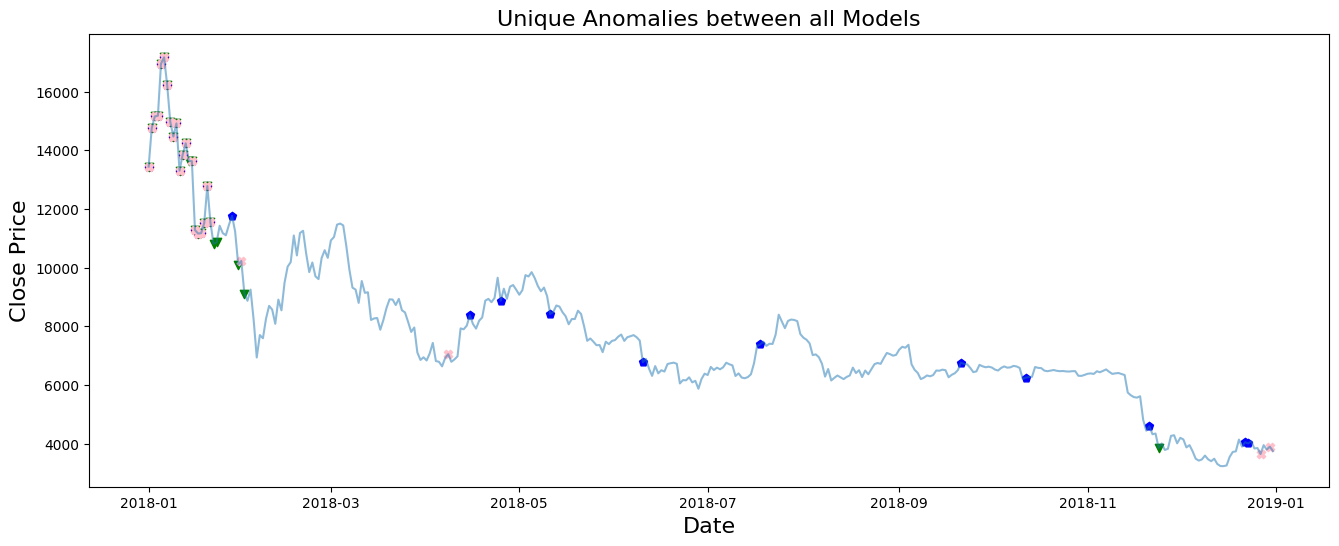

In [243]:
# filter for same dates 
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.pyplot as plt
# Converting the index as date
price.index = pd.to_datetime(price.index)
#common = \
#   set.intersection(set(price.index), set(three_datasets_close.index))
#filter1 = price[price.index.isin(common)]
#filter1 = filter1[['close']]

# Alter size for the plot
plt.subplots(dpi=100,figsize=(16,6))
# plot all close price data
plt.plot(price.index, price.close,  alpha=0.5)
# set x-axis label and specific size
plt.xlabel('Date',size=16)
# set y-axis label and specific size
plt.ylabel('Close Price',size=16)
# set plot title with specific size
plt.title('Unique Anomalies between all Models',size=16)

# plot anomalies 
plt.scatter(three_datasets_close.index, three_datasets_close.Close, color="red", marker = 'H')
plt.scatter(price_block_close.index, price_block_close.Close, color="blue", marker = 'p')
plt.scatter(price_social_close.index, price_social_close.Close, color="green", marker = 'v')
plt.scatter(block_social_close.index, block_social_close.Close, color="pink", marker = 'X')

plt.show()

# Anomaly Detection on all 3 datasets together

In [193]:
# merge the 3 datasets 
merged_df = pd.concat([price,block,social], axis = 1)
# scale them 
X = scale(merged_df)
print(X.shape)
X.describe()

(365, 95)


,close,high,low,open,volumefrom,volumeto,CCI,ichimoku_leadSpanA,ichimoku_leadSpanB,MACD,...,reddit_posts_per_day,reddit_comments_per_hour,reddit_comments_per_day,code_repo_stars,code_repo_forks,code_repo_subscribers,code_repo_open_pull_issues,code_repo_closed_pull_issues,code_repo_open_issues,code_repo_closed_issues
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,...,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,0.309506,0.323185,0.314349,0.311447,0.158511,0.165547,0.610031,0.360129,0.336818,0.567335,...,0.278695,0.196713,0.196708,0.648723,0.680061,0.737169,0.414537,0.500259,0.401739,0.542089
std,0.173618,0.181712,0.171755,0.174608,0.120752,0.150214,0.147846,0.207782,0.236865,0.167418,...,0.169271,0.163744,0.163743,0.265907,0.266401,0.255689,0.215412,0.301799,0.244852,0.291751
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.225885,0.230769,0.236921,0.226146,0.077413,0.061453,0.505965,0.254712,0.192137,0.470921,...,0.175227,0.090028,0.090025,0.471224,0.511847,0.601688,0.258824,0.239695,0.211538,0.327409
50%,0.264223,0.276441,0.267946,0.264287,0.124178,0.117303,0.592183,0.305660,0.234630,0.598206,...,0.260633,0.149065,0.149058,0.697656,0.740560,0.814346,0.400000,0.491935,0.365385,0.547240
75%,0.386708,0.406506,0.391708,0.390215,0.211678,0.220504,0.726902,0.458545,0.416687,0.650943,...,0.331805,0.240735,0.240726,0.875716,0.915828,0.947679,0.541176,0.773297,0.602564,0.781104
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 5.1 Run Models

In [194]:
# time the code
import time
t0 = time.time()

# empty list to store outliers and inliners
df_outliers = []
scores_pred_lst = []
proba_lst = []
predict_rank_lst = []

# iterate over different outlier fractions 
for fraction in outliers_fraction:
    classifiers = {#'AE' : AutoEncoder(contamination=outliers_fraction, random_state=random_state), # check why error
               'ABOD': ABOD(contamination = fraction),
              'CBLOF':CBLOF(check_estimator=False, random_state=random_state), # getting 0 
              'FB':FeatureBagging(LOF(n_neighbors=35),contamination=fraction,check_estimator=False,random_state=random_state),
              'HBOS': HBOS(contamination=fraction),
              'IF': IForest(contamination=fraction,random_state=random_state),
              'KNN': KNN(contamination=fraction),
              'Average KNN': KNN(method='mean',contamination=fraction),
              'OCSVM' : OCSVM(contamination=fraction),
              'SOS' : SOS(contamination=fraction),
              'LOF': LOF(n_neighbors=35, contamination = fraction),
              #'LOCI': LOCI(contamination = fraction), # takes a super long time + don't understand
              'VAE' : VAE(contamination=fraction, random_state=random_state) # default nbr of neurons too much for blockchain dataset
              }

    for i, (clf_name, clf) in enumerate(classifiers.items()):
        clf.fit(X)
        # predict raw anomaly score
        scores_pred = clf.decision_function(X) * -1 # WHY? * -1

        # prediction of a datapoint category outlier or inlier
        y_pred = clf.predict(X)

        # probability of outlier 
        probability = clf.predict_proba(X, method = 'linear')

        # predict rank
        predict_rank = clf._predict_rank(X)

        n_inliers = len(y_pred) - np.count_nonzero(y_pred)
        n_outliers = np.count_nonzero(y_pred == 1)

        # copy of dataframe
        dfx = X.copy()

        dfx[clf_name] = y_pred.tolist()
        #print(clf_name,'\n',i,clf,'\n',classifiers,'\n',classifiers.items())
        print('Outlier fraction: ', fraction)
        print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)
        #print('scores_pred: ', scores_pred)
        scores_pred_lst.append(scores_pred)
        df_outliers.append(dfx[clf_name]) 
        proba_lst.append(probability)
        predict_rank_lst.append(predict_rank)
t1 = time.time()
total = t1-t0

Outlier fraction:  0.01
OUTLIERS :  5 INLIERS :  360 ABOD
Outlier fraction:  0.01
OUTLIERS :  37 INLIERS :  328 CBLOF
Outlier fraction:  0.01
OUTLIERS :  3 INLIERS :  362 FB
Outlier fraction:  0.01
OUTLIERS :  4 INLIERS :  361 HBOS
Outlier fraction:  0.01
OUTLIERS :  4 INLIERS :  361 IF
Outlier fraction:  0.01
OUTLIERS :  4 INLIERS :  361 KNN
Outlier fraction:  0.01
OUTLIERS :  2 INLIERS :  363 Average KNN
Outlier fraction:  0.01
OUTLIERS :  4 INLIERS :  361 OCSVM
Outlier fraction:  0.01
OUTLIERS :  4 INLIERS :  361 SOS
Outlier fraction:  0.01
OUTLIERS :  3 INLIERS :  362 LOF
Model: "model_46"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           (None, 95)           0                                            
__________________________________________________________________________________________________
den

/home/jupyter-ehren/.local/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output model_47 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_47.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 328 samples, validate on 37 samples
Epoch 1/100
328/328 [==============================] - 1s 2ms/step - loss: 201.1140 - val_loss: 168.9893
Epoch 2/100
328/328 [==============================] - 0s 106us/step - loss: 128.0586 - val_loss: 149.0081
Epoch 3/100
328/328 [==============================] - 0s 106us/step - loss: 113.4524 - val_loss: 140.0210
Epoch 4/100
328/328 [==============================] - 0s 104us/step - loss: 102.9605 - val_loss: 132.6620
Epoch 5/100
328/328 [==============================] - 0s 105us/step - loss: 94.8861 - val_loss: 128.7056
Epoch 6/100
328/328 [==============================] - 0s 115us/step - loss: 92.5830 - val_loss: 127.7743
Epoch 7/100
328/328 [==============================] - 0s 107us/step - loss: 91.7504 - val_loss: 127.8181
Epoch 8/100
328/328 [==============================] - 0s 108us/step - loss: 91.5240 - val_loss: 127.8586
Epoch 9/100
328/328 [==============================] - 0s 121us/step - loss: 91.4562 - val_loss: 127.6834

/home/jupyter-ehren/.local/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output model_50 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_50.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 328 samples, validate on 37 samples
Epoch 1/100
328/328 [==============================] - 1s 2ms/step - loss: 172.4198 - val_loss: 144.5460
Epoch 2/100
328/328 [==============================] - 0s 107us/step - loss: 124.9403 - val_loss: 129.9914
Epoch 3/100
328/328 [==============================] - 0s 109us/step - loss: 113.1190 - val_loss: 118.9907
Epoch 4/100
328/328 [==============================] - 0s 109us/step - loss: 104.6038 - val_loss: 112.4133
Epoch 5/100
328/328 [==============================] - 0s 122us/step - loss: 98.5811 - val_loss: 105.9590
Epoch 6/100
328/328 [==============================] - 0s 107us/step - loss: 95.5526 - val_loss: 104.6024
Epoch 7/100
328/328 [==============================] - 0s 108us/step - loss: 94.6774 - val_loss: 104.1997
Epoch 8/100
328/328 [==============================] - 0s 122us/step - loss: 94.3106 - val_loss: 103.8948
Epoch 9/100
328/328 [==============================] - 0s 106us/step - loss: 94.3481 - val_loss: 103.7467

/home/jupyter-ehren/.local/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output model_53 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_53.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 328 samples, validate on 37 samples
Epoch 1/100
328/328 [==============================] - 1s 2ms/step - loss: 190.9265 - val_loss: 125.1490
Epoch 2/100
328/328 [==============================] - 0s 106us/step - loss: 129.3091 - val_loss: 112.3281
Epoch 3/100
328/328 [==============================] - 0s 105us/step - loss: 118.2768 - val_loss: 104.8602
Epoch 4/100
328/328 [==============================] - 0s 105us/step - loss: 109.0500 - val_loss: 97.5324
Epoch 5/100
328/328 [==============================] - 0s 104us/step - loss: 100.3369 - val_loss: 92.1590
Epoch 6/100
328/328 [==============================] - 0s 103us/step - loss: 96.9437 - val_loss: 90.0257
Epoch 7/100
328/328 [==============================] - 0s 105us/step - loss: 95.9466 - val_loss: 90.0984
Epoch 8/100
328/328 [==============================] - 0s 114us/step - loss: 95.8494 - val_loss: 89.9976
Epoch 9/100
328/328 [==============================] - 0s 106us/step - loss: 95.7871 - val_loss: 89.8579
Epoc

/home/jupyter-ehren/.local/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output model_56 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_56.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 328 samples, validate on 37 samples
Epoch 1/100
328/328 [==============================] - 1s 2ms/step - loss: 184.5029 - val_loss: 125.3141
Epoch 2/100
328/328 [==============================] - 0s 111us/step - loss: 126.6926 - val_loss: 109.0433
Epoch 3/100
328/328 [==============================] - 0s 111us/step - loss: 112.5516 - val_loss: 100.7934
Epoch 4/100
328/328 [==============================] - 0s 109us/step - loss: 102.9088 - val_loss: 94.3222
Epoch 5/100
328/328 [==============================] - 0s 114us/step - loss: 97.7263 - val_loss: 94.0849
Epoch 6/100
328/328 [==============================] - 0s 123us/step - loss: 95.8525 - val_loss: 93.8703
Epoch 7/100
328/328 [==============================] - 0s 110us/step - loss: 95.4151 - val_loss: 93.6245
Epoch 8/100
328/328 [==============================] - 0s 109us/step - loss: 95.3412 - val_loss: 93.7695
Epoch 9/100
328/328 [==============================] - 0s 125us/step - loss: 95.3158 - val_loss: 93.8818
Epoch

/home/jupyter-ehren/.local/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output model_59 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_59.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 328 samples, validate on 37 samples
Epoch 1/100
328/328 [==============================] - 1s 2ms/step - loss: 188.9680 - val_loss: 97.1623
Epoch 2/100
328/328 [==============================] - 0s 107us/step - loss: 131.6875 - val_loss: 84.4780
Epoch 3/100
328/328 [==============================] - 0s 110us/step - loss: 119.2679 - val_loss: 75.6607
Epoch 4/100
328/328 [==============================] - 0s 125us/step - loss: 108.8292 - val_loss: 65.3516
Epoch 5/100
328/328 [==============================] - 0s 110us/step - loss: 101.8323 - val_loss: 62.6148
Epoch 6/100
328/328 [==============================] - 0s 106us/step - loss: 99.5158 - val_loss: 61.6615
Epoch 7/100
328/328 [==============================] - 0s 124us/step - loss: 99.2086 - val_loss: 61.5472
Epoch 8/100
328/328 [==============================] - 0s 107us/step - loss: 99.0589 - val_loss: 61.4632
Epoch 9/100
328/328 [==============================] - 0s 107us/step - loss: 98.9991 - val_loss: 61.2825
Epoch 1

In [195]:
print('Time to run: ',total,'s')
# we have 50 lists (or essentially 5 with 10 models)
print(len(df_outliers))

Time to run:  44.128012895584106 s
55


In [201]:
# save the outliers lists uniquely for later
allthree_df_s = df_outliers
# probability lists
allthree_proba_s = proba_lst
# rank lists
allthree_rank_s = predict_rank_lst

### 5.2 Seperate models per contamination

In [60]:
# unpack lists based on outlier fraction e.g. first 10 = 0.01 outlier fraction
frac_oo1 = df_outliers[0:11]
frac_oo2 = df_outliers[11:22]
frac_oo3 = df_outliers[22:33]
frac_oo4 = df_outliers[33:44]
frac_oo5 = df_outliers[44:]

# use the function to extract the dates
frac_oo1_outliers = outlier_subset_function(frac_oo1)
frac_oo2_outliers = outlier_subset_function(frac_oo2)
frac_oo3_outliers = outlier_subset_function(frac_oo3)
frac_oo4_outliers = outlier_subset_function(frac_oo4)
frac_oo5_outliers = outlier_subset_function(frac_oo5)

### 5.3 Get unique dates per anomaly contamination

In [197]:
dates_per_fraction(frac_oo1_outliers,frac_oo2_outliers,frac_oo3_outliers,frac_oo4_outliers,frac_oo5_outliers)

Outlier fraction 0.01 unique dates:  37
Outlier fraction 0.02 unique dates:  38
Outlier fraction 0.03 unique dates:  40
Outlier fraction 0.04 unique dates:  44
Outlier fraction 0.05 unique dates:  48


### 5.4 Anomaly likelihood

In [196]:
allthree_anomalies = date_ranking(frac_oo1_outliers,frac_oo2_outliers,frac_oo3_outliers,frac_oo4_outliers,frac_oo5_outliers)
print('Unique Anomaly Dates: ',len(allthree_anomalies.Date.unique()))
allthree_anomalies

Unique Anomaly Dates:  48


,Date,AllContaminations_Vote,ModelAnomaly_Vote,weight_anomaly_models
4,2018-04-08,5,35,0.060870
36,2018-01-16,5,31,0.053913
30,2018-01-17,5,30,0.052174
27,2018-01-02,5,25,0.043478
17,2018-01-05,5,23,0.040000
20,2018-01-01,5,22,0.038261
16,2018-01-09,5,21,0.036522
1,2018-02-01,5,20,0.034783
2,2018-09-10,5,20,0.034783
3,2018-01-06,5,19,0.033043


### 5.5 Borderline probability analysis

In [202]:
allthree_proba_s[0][:10]

array([[4.03208341e-04, 9.99596792e-01],
       [3.44879937e-03, 9.96551201e-01],
       [1.79113641e-02, 9.82088636e-01],
       [5.98103490e-03, 9.94018965e-01],
       [2.70745040e-03, 9.97292550e-01],
       [1.62647169e-03, 9.98373528e-01],
       [1.31880221e-02, 9.86811978e-01],
       [5.48687835e-03, 9.94513122e-01],
       [4.57138893e-03, 9.95428611e-01],
       [6.37301930e-03, 9.93626981e-01]])

In [213]:
allthree_datasets_close = close_prices_anomalies(allthree_anomalies.Date)

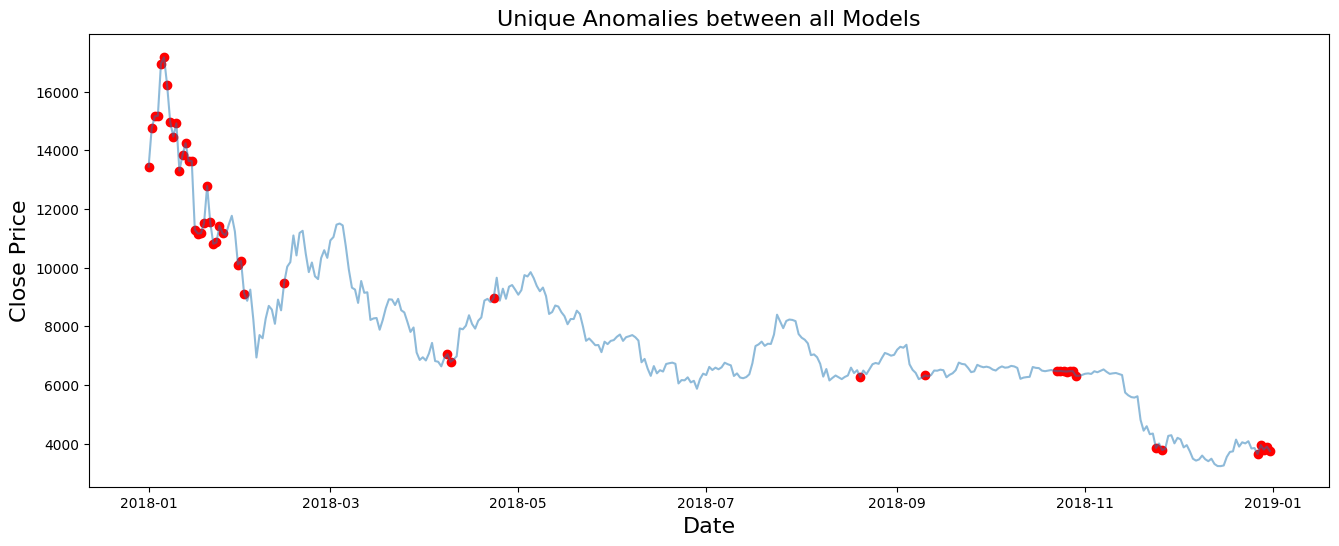

In [218]:
# Converting the index as date
price.index = pd.to_datetime(price.index)
common = \
   set.intersection(set(price.index), set(allthree_datasets_close.index))
filter1 = price[price.index.isin(common)]
filter1 = filter1[['close']]

# Alter size for the plot
plt.subplots(dpi=100,figsize=(16,6))
# plot all close price data
plt.plot(price.index, price.close,  alpha=0.5)
# set x-axis label and specific size
plt.xlabel('Date',size=16)
# set y-axis label and specific size
plt.ylabel('Close Price',size=16)
# set plot title with specific size
plt.title('Unique Anomalies between all Models',size=16)

# plot anomalies 
plt.scatter(filter1.index, filter1.close, color="red")
plt.show()

## Leave-one-out

In [ ]:
# slice into 365 - 1
# test with 1 model 
for idx, row in X.iterrows(): # that row is the thing to test
    # remainder user for training, remove row from dataframe and that row becomes your testing in that round
    X_pred = 0
    X_test = row
    X_train = X.drop(idx,axis=0)
    
    #clf = IForest(contamination=0.05,random_state=123)
    clf = KNN(method='mean',contamination=0.03)
    clf.fit(X_train)
    
    X_test = X_test.values.reshape(1,-1)
    
    X_pred = clf.predict(X_test)
    print(X_pred)
    # save everything after each round

In [62]:
# getting all close price values 
close_anomalies = []
for dates in allthree_anomalies['Date']:
    # get close price 
    d = X.loc[str(dates),'close']
    close_anomalies.append(d)
close_anomalies = pd.Series(close_anomalies)
table_dates = allthree_anomalies['Date']
anomalies = pd.concat([table_dates,close_anomalies], axis = 1)
anomalies.columns = ['Date','Close']
anomalies.Date = pd.to_datetime(anomalies.Date)

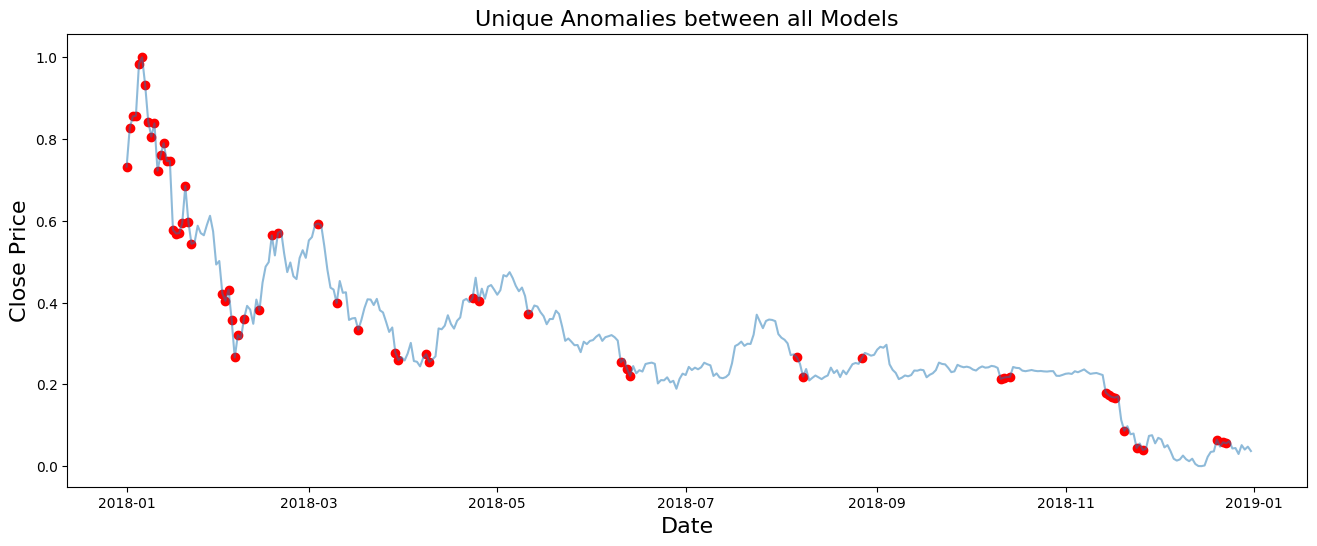

In [68]:
# filter for same dates 
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.pyplot as plt
common = \
    set.intersection(set(X.index), set(anomalies.Date))
filter1 = X[X.index.isin(common)]
filter1 = filter1[['close']]

# Converting the index as date
X.index = pd.to_datetime(X.index)
# Alter size for the plot
plt.subplots(dpi=100,figsize=(16,6))
# plot all close price data
plt.plot(X.index, X.close,  alpha=0.5)
# set x-axis label and specific size
plt.xlabel('Date',size=16)
# set y-axis label and specific size
plt.ylabel('Close Price',size=16)
# set plot title with specific size
plt.title('Unique Anomalies between all Models',size=16)

# plot anomalies 
plt.scatter(filter1.index, filter1.close, color="red")
plt.show()

In [73]:
def close_prices_anomalies(anomaly_df, main_df):
    # getting all close price values 
    close_anomalies = []
    for dates in anomaly_df['Date']:
        # get close price 
        d = main_df.loc[str(dates),'close']
        close_anomalies.append(d)
    close_anomalies = pd.Series(close_anomalies)
    table_dates = allthree_anomalies['Date']
    anomalies = pd.concat([table_dates,close_anomalies], axis = 1)
    anomalies.columns = ['Date','Close']
    anomalies.Date = pd.to_datetime(anomalies.Date)
    return anomalies 

In [70]:
def plot_anomalies(main_df, anomaly_df):
    common = \
    set.intersection(set(main_df.index), set(anomaly_df.Date))
    filter1 = main_df[main_df.index.isin(common)]
    filter1 = filter1[['close']]

    # Converting the index as date
    main_df.index = pd.to_datetime(main_df.index)
    # Alter size for the plot
    plt.subplots(dpi=100,figsize=(16,6))
    # plot all close price data
    plt.plot(main_df.index, main_df.close,  alpha=0.5)
    # set x-axis label and specific size
    plt.xlabel('Date',size=16)
    # set y-axis label and specific size
    plt.ylabel('Close Price',size=16)
    # set plot title with specific size
    plt.title('Unique Anomalies between all Models',size=16)

    # plot anomalies 
    plt.scatter(filter1.index, filter1.close, color="red")
    plt.show()

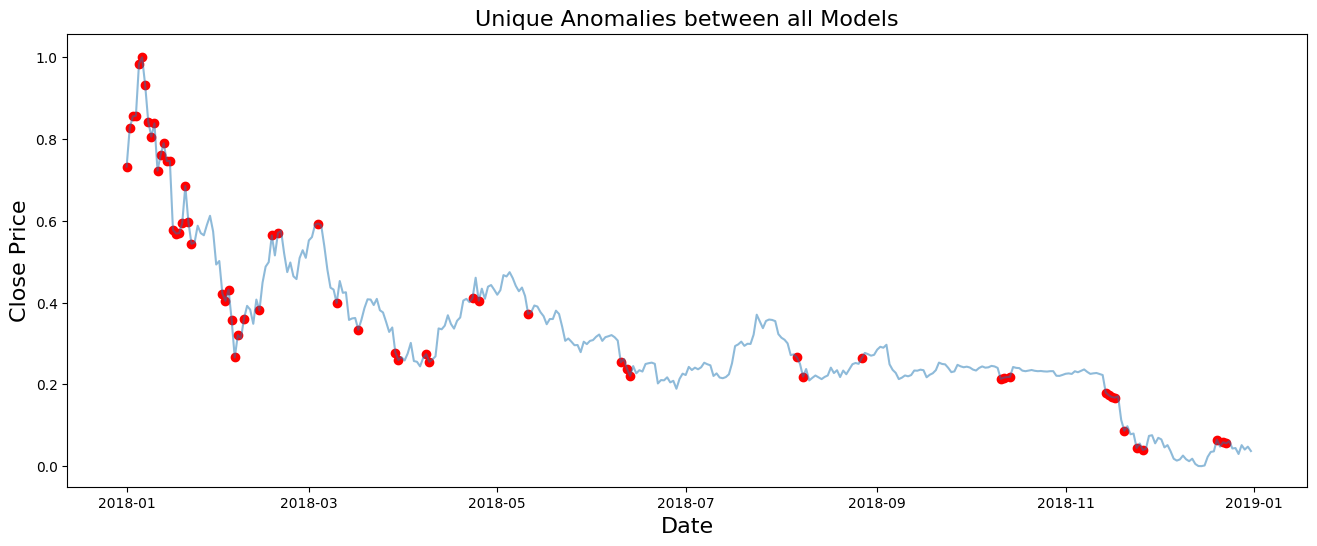

In [71]:
plot_anomalies(X,anomalies)

- it would be interesting to see if there are any "signals" for data identified as an anomaly right before price **spikes** or **drops**
- I would say major anomalies were flagged but some are still missing (visially) granted only 5 models were used

In [ ]:
# green color for those voted by 2 
# different colors for years 

## To Be Continued 

## Probability

In [ ]:
outlier_proba = np.transpose(pd.DataFrame(probability)).T
outlier_proba.index = X.index
#outlier_proba

## Outlier Date Counts

In [ ]:
btc_outliers = np.transpose(pd.DataFrame(df_outliers))
#btc_outliers

## Predict Rank Scores

In [ ]:
pred_rank_df = np.transpose(pd.DataFrame(predict_rank_lst))
pred_rank_df.columns = classifiers.keys()
pred_rank_df.index = merged_df.index
#pred_rank_df

# Intersection Between Merge and different datasets

In [ ]:
# number of outliers identified per method 
outlier_dates = [] # store dates here 
for col in btc_outliers.columns:
    outliers = btc_outliers[btc_outliers[col] == 1] # subset outlier data
    #df_outliers.timestamp.apply(lambda x: x.strftime('%Y-%m-%d')) # datetime to string 
    outlier_dates.append(outliers.index) # append the string/date

In [ ]:
print('Nbr of common anomalies among all models: ',len(intersection(outlier_dates[0],outlier_dates[1],outlier_dates[2],
        outlier_dates[3],outlier_dates[4],outlier_dates[5],outlier_dates[6])))

## CBLOF intersection dates across tests (arbitrary model check)

In [ ]:
[x for x in three[3] if x in prices_df[3]]

In [ ]:
def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2))

In [ ]:
# prices and blockchain
intersection(prices_df[1], block_df[1])

In [ ]:
intersection(prices_df[1], social_df[1])

In [ ]:
dates_knn = list(btc_outliers[btc_outliers['K Nearest Neighbors (KNN)']==1].index)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3)  # Reduce to k=3 dimensions
X_reduce = pca.fit_transform(X)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")
# Plot the compressed data points
ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=4, lw=1, label="inliers",c="green")
# Plot x's for the ground truth outliers
ax.scatter(X_reduce[dates_knn,0],X_reduce[dates_knn,1], X_reduce[dates_knn,2],
           lw=2, s=60, marker="x", c="red", label="outliers")
ax.legend()
plt.show()

In [ ]:
from pyod.models.knn import KNN

clf_name = 'KNN'
clf = KNN(contamination=0.05)
clf.fit(X.values)

In [ ]:
# predict raw anomaly score 
# np.set_printoptions(precision=None)

#clf.decision_scores_

scores_pred = clf.decision_function(X) 
print(scores_pred.shape)

In [ ]:
# get the prediction on the test data
y_pred = clf.predict(X)  # outlier labels (0 or 1)
print(y_pred.shape)
n_inliers = len(y_pred) - np.count_nonzero(y_pred)
n_outliers = np.count_nonzero(y_pred == 1)
print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)
# threshold value to consider a datapoint inlier or outlier
threshold = stats.scoreatpercentile(scores_pred,100 * 0.05)
threshold